# Image captions

By default, the loader utilizes the pre-trained [Salesforce BLIP image captioning model](https://huggingface.co/Salesforce/blip-image-captioning-base).

This notebook shows how to use the `ImageCaptionLoader` to generate a queryable index of image captions.

In [ ]:
%pip install -qU transformers langchain_openai langchain_chroma

import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

### Prepare a list of image urls from Wikimedia

In [2]:
from langchain_community.document_loaders import ImageCaptionLoader

list_image_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Ara_ararauna_Luc_Viatour.jpg/1554px-Ara_ararauna_Luc_Viatour.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/1928_Model_A_Ford.jpg/640px-1928_Model_A_Ford.jpg",
]

### Create the loader

In [3]:
loader = ImageCaptionLoader(images=list_image_urls)
list_docs = loader.load()
list_docs

[Document(metadata={'image_path': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Ara_ararauna_Luc_Viatour.jpg/1554px-Ara_ararauna_Luc_Viatour.jpg'}, page_content='an image of a bird flying in the air [SEP]'),
 Document(metadata={'image_path': 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/1928_Model_A_Ford.jpg/640px-1928_Model_A_Ford.jpg'}, page_content='an image of a vintage car parked on the street [SEP]')]

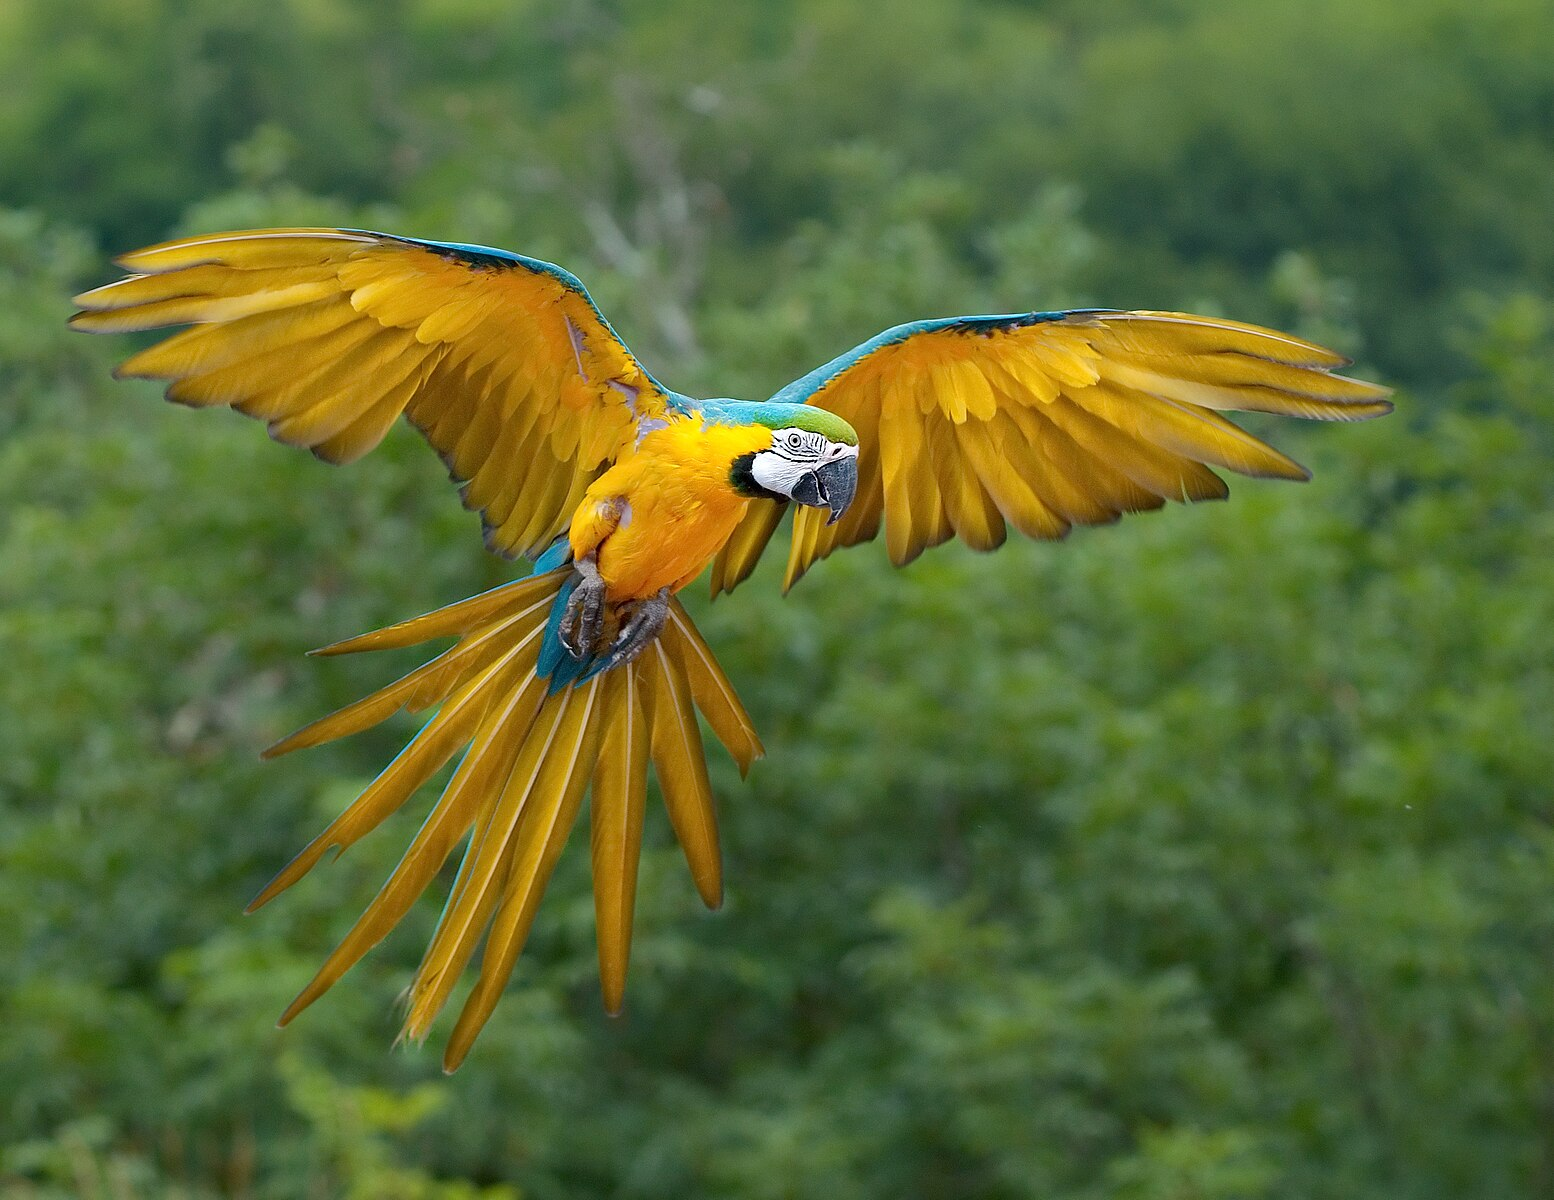

In [4]:
import requests
from PIL import Image

Image.open(requests.get(list_image_urls[0], stream=True).raw).convert("RGB")

### Create the index

In [8]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(list_docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever(k=2)

### Query

In [9]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(model, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

response = rag_chain.invoke({"input": "What animals are in the images?"})

print(response["answer"])

The images include a bird.


In [10]:
response = rag_chain.invoke({"input": "What kind of images are there?"})

print(response["answer"])

There are images of a bird flying in the air and a vintage car parked on the street.
